In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Tensorflow-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models


In [ ]:
# Clone KerasCV
!git clone https://github.com/keras-team/keras-cv.git

Cloning into 'keras-cv'...
remote: Enumerating objects: 14042, done.
remote: Counting objects: 100% (1159/1159), done.
remote: Compressing objects: 100% (703/703), done.
remote: Total 14042 (delta 763), reused 456 (delta 456), pack-reused 12883 (from 4)
Receiving objects: 100% (14042/14042), 26.21 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (9650/9650), done.
Updating files: 100% (725/725), done.


In [2]:
%cd kerascv/

/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models/kerascv


In [ ]:
# install and restart
!pip install -e .

In [4]:
%cd ..

/content/gdrive/.shortcut-targets-by-id/1oP3ewZgiatY88SU5esvVcTCqbdfjYu1d/Tensorflow-Models


In [2]:
import os
import sys
sys.path.append("/content/gdrive/My Drive/Tensorflow-Models/kerascv/keras_cv")

In [5]:
import keras_cv
from keras_cv import *

In [6]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import numpy as np
import pycocotools
from tensorflow import keras
print("tensorflow" + tf.__version__)
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from keras.callbacks import LambdaCallback
print("keras_cv" + keras_cv.__version__)
device_name = tf.test.gpu_device_name()

if "GPU" in device_name:
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU not found.')

tensorflow2.19.0
keras_cv0.10.0
Found GPU at: /device:GPU:0


In [7]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

def visualize_detections(model, dataset, bounding_box_format, rows=2, cols=2):
    images, y_true = next(iter(dataset.take(1)))

    #tf.config.run_functions_eagerly(True)

    y_pred = model.predict(images)

    #tf.config.run_functions_eagerly(False)

    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=rows,
        cols=cols,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [8]:
class_mapping = {
    1: 'acv',
    2: 'c',
    3: 'i',
    4: 'l',
    5: 'r',
    6: 'v',
}

In [9]:
train_tfrecord_file = '/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitiontfrecord/train/Predict-circuit-parameters.tfrecord'
val_tfrecord_file = '/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitiontfrecord/valid/Predict-circuit-parameters.tfrecord'

# Create a TFRecordDataset
train_dataset = tf.data.TFRecordDataset([train_tfrecord_file])
val_dataset = tf.data.TFRecordDataset([val_tfrecord_file])

# Iterate over a few entries and print their content. Uncomment this to look at the raw data
for record in train_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(record.numpy())
    print(example)

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\000\260\001)\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\203\204\205\206\207\210\211\212\222\223\224\225\226\227\230\231\232\242\243\244\245\246\247

In [10]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode the JPEG image and normalize the pixel values to the [0, 1] range.
    img = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3) # Returned as uint8
    # Normalize the pixel values to [0, 256]
    img = tf.image.convert_image_dtype(img, tf.uint8)

    # Get the bounding box coordinates and class labels.
    xmin = tf.sparse.to_dense(parsed_example['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed_example['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed_example['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed_example['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed_example['image/object/class/label'])

    # Stack the bounding box coordinates to create a [num_boxes, 4] tensor.
    rel_boxes = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
    boxes = keras_cv.bounding_box.convert_format(rel_boxes, source='rel_xyxy', target='xyxy', images=img)

    # Create the final dictionary.
    image_dataset = {
        'images': img,
        'bounding_boxes': {
            'classes': labels,
            'boxes': boxes
        }
    }

    return image_dataset

train_dataset = train_dataset.map(parse_tfrecord_fn)
val_dataset = val_dataset.map(parse_tfrecord_fn)

# Inspecting the data
for data in train_dataset.take(1):
    print(data)

{'images': <tf.Tensor: shape=(176, 297, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  3,   3,   3],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [205, 205, 205]],

       [[  1,   1,   1],
        [  4,   4,   4],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [199, 199, 199]],

       [[  2,   2,   2],
        [  4,   4,   4],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [190, 190, 190]],

       ...,

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [  4,   4,   4],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  2,   2,   2],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [ 

In [11]:
# Batching
BATCH_SIZE = 4
# Adding autotune for pre-fetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Other constants
NUM_ROWS = 1
NUM_COLS = 4
IMG_SIZE = 416
BBOX_FORMAT = "xyxy"

train_dataset = train_dataset.ragged_batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.ragged_batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# # For the training dataset, add .repeat()
# train_dataset = train_dataset.ragged_batch(BATCH_SIZE).repeat().prefetch(buffer_size=AUTOTUNE)

# # For the validation dataset, .repeat() is optional but generally omitted
# val_dataset = val_dataset.ragged_batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

augmenter = keras.Sequential(
    [
        keras_cv.layers.JitteredResize(
            target_size=(IMG_SIZE, IMG_SIZE), scale_factor=(0.8, 1.25), bounding_box_format=BBOX_FORMAT
        ),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format=BBOX_FORMAT),
        keras_cv.layers.RandomRotation(factor=0.1, bounding_box_format=BBOX_FORMAT),
        keras_cv.layers.RandomSaturation(factor=(0.4, 0.6)),
        keras_cv.layers.RandomHue(factor=0.2, value_range=[0,255])
    ]
)

train_dataset = train_dataset.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Resize and pad images
inference_resizing = keras_cv.layers.Resizing(
    IMG_SIZE, IMG_SIZE, pad_to_aspect_ratio=True, bounding_box_format=BBOX_FORMAT
)

val_dataset = val_dataset.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

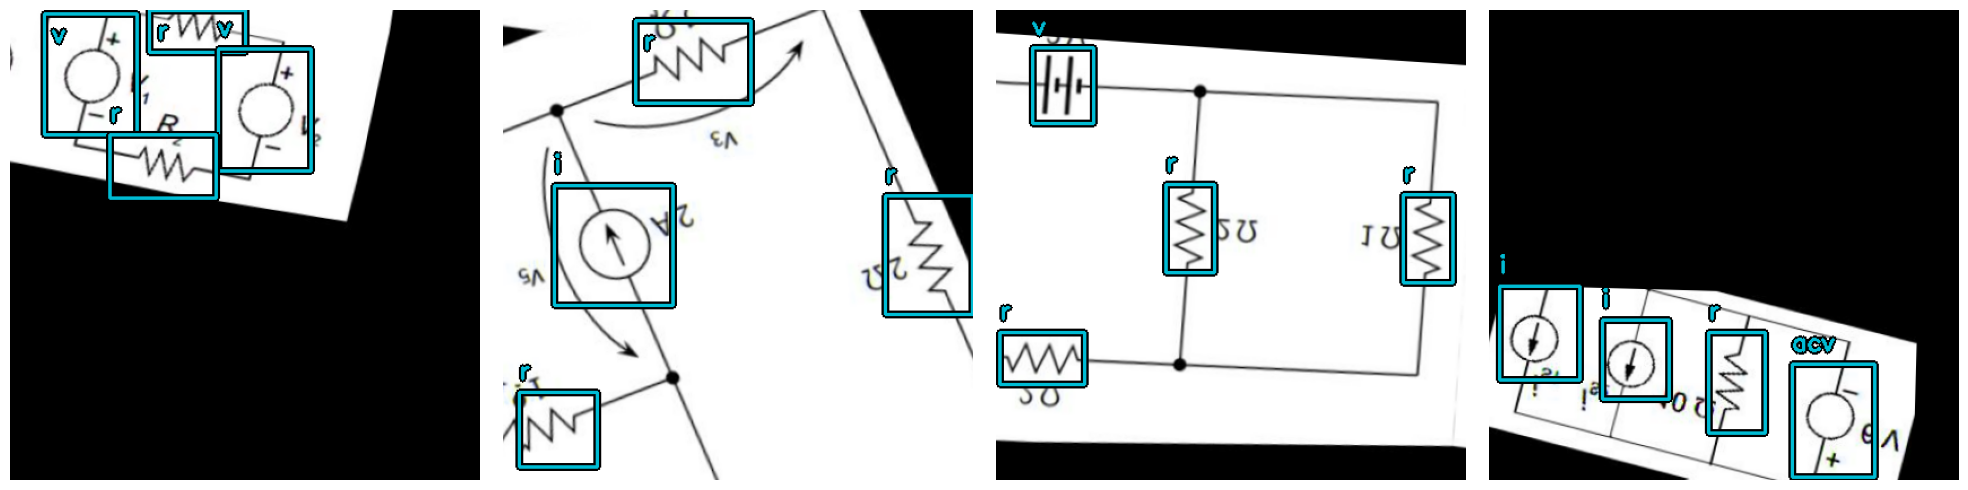

In [ ]:
# Visualize training set
visualize_dataset(
    train_dataset, bounding_box_format=BBOX_FORMAT, value_range=(0, 255), rows=NUM_ROWS, cols=NUM_COLS
)

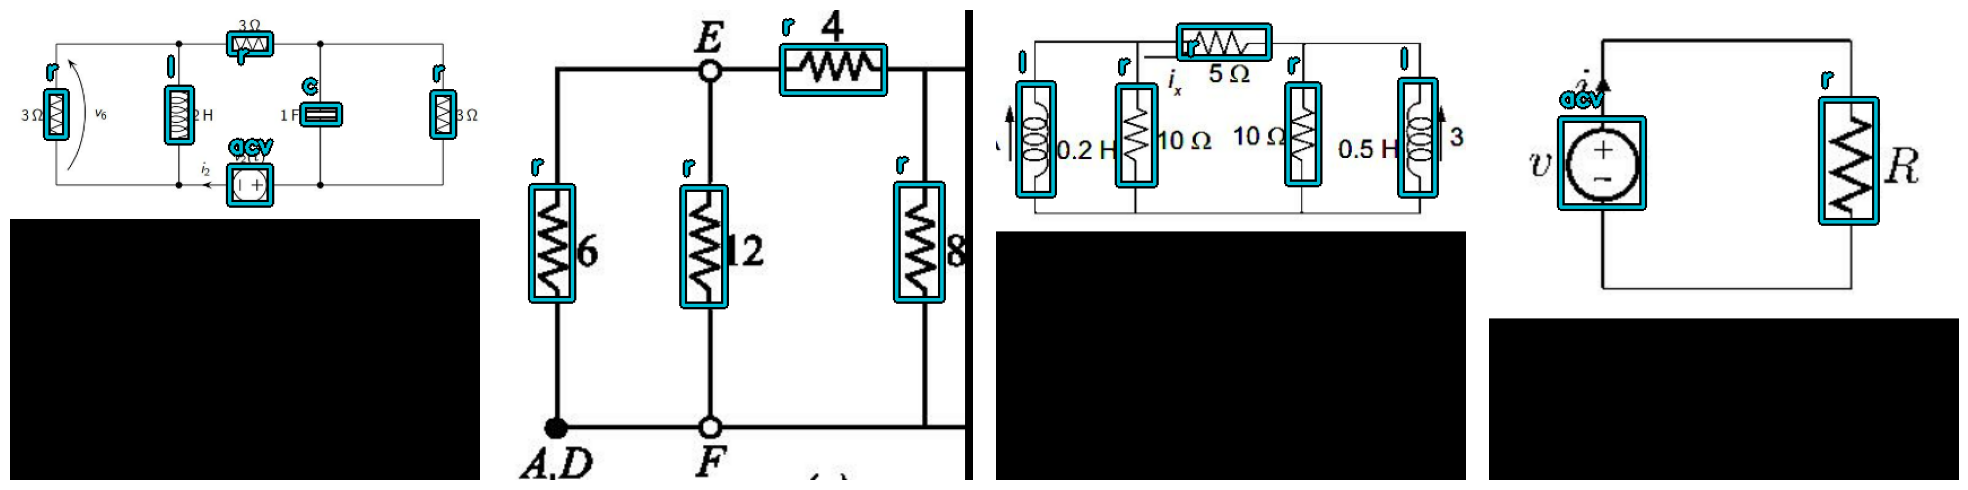

In [ ]:
# Visualize validation set
visualize_dataset(
    val_dataset, bounding_box_format=BBOX_FORMAT, value_range=(0, 255), rows=NUM_ROWS, cols=NUM_COLS
)

In [12]:
train_dataset = train_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
print(len(class_mapping))

6


In [14]:
from keras_cv.api.models import faster_rcnn

In [15]:
# Building a Faster-RCNN model with a backbone trained on resnet
def create_model():
    model = keras_cv.models.FasterRCNN(
        num_classes=len(class_mapping),
        bounding_box_format=BBOX_FORMAT,
        backbone=keras_cv.models.ResNet18V2Backbone(
            input_shape=(416, 416, 3)
        ))
    return model

model = create_model()
model.summary()

100%|██████████| 877/877 [00:00<00:00, 2.07MB/s]


Model: "faster_rcnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 416, 416,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 104, 104, │ 11,181,440 │ images[0][0]      │
│ (Functional)        │ 64), (None, 52,   │            │                   │
│                     │ 52, 128), (None,  │            │                   │
│                     │ 26, 26, 256),     │            │                   │
│                     │ (None, 13, 13,    │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid     │ [(None, 104, 104, │  2,607,104 │ functional[0][0], │
│ (FeaturePyramid)    │ 256), (None, 52,  │            │ functional[0][1], │
│                     │ 52, 256), (None,  │            │ functional[0][2], │
│                     │ 26, 26, 256),     │            │ functional[0][3]  │
│                     │ (None, 13, 13,    │            │                   │
│                     │ 256), (None, 7,   │            │                   │
│                     │ 7, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rpn_head (RPNHead)  │ [(None, 104, 104, │    593,935 │ feature_pyramid[… │
│                     │ 12), (None, 52,   │            │ feature_pyramid[… │
│                     │ 52, 12), (None,   │            │ feature_pyramid[… │
│                     │ 26, 26, 12),      │            │ feature_pyramid[… │
│                     │ (None, 13, 13,    │            │ feature_pyramid[… │
│                     │ 12), (None, 7, 7, │            │                   │
│                     │ 12), (None, 104,  │            │                   │
│                     │ 104, 3), (None,   │            │                   │
│                     │ 52, 52, 3),       │            │                   │
│                     │ (None, 26, 26,    │            │                   │
│                     │ 3), (None, 13,    │            │                   │
│                     │ 13, 3), (None, 7, │            │                   │
│                     │ 7, 3)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32448, 4)  │          0 │ rpn_head[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 8112, 4)   │          0 │ rpn_head[0][1]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 2028, 4)   │          0 │ rpn_head[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 507, 4)    │          0 │ rpn_head[0][3]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 147, 4)    │          0 │ rpn_head[0][4]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32448, 4)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 8112, 4)   │          0 │ reshape_1[0][0]   │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 2028, 4)   │          0 │ reshape_2[0][0]   │
│ (Multiply)          │                   │            │                 

 Total params: 28,289,434 (107.92 MB)

 Trainable params: 28,282,650 (107.89 MB)

 Non-trainable params: 6,784 (26.50 KB)

In [16]:
base_lr = 0.005
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [17]:
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format=BBOX_FORMAT, evaluate_freq=5
)

model.compile(
    optimizer=optimizer,
    box_loss="Huber",
    classification_loss="CategoricalCrossentropy",
    rpn_box_loss="Huber",
    rpn_classification_loss="BinaryCrossentropy",
    metrics=[coco_metrics],
)

In [ ]:
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if (epoch+1)%2==0:
            visualize_detections(
                self.model, bounding_box_format=BBOX_FORMAT, dataset=val_dataset, rows=NUM_ROWS, cols=NUM_COLS
            )

checkpoint_path="circuitfasterrcnnmodel.weights.h5"

callbacks_list = [
    # Conducting early stopping to stop after 5 epochs of non-improving validation loss
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
    ),

    # Saving the best model
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    ),

    # Custom metrics printing after each epoch
    tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs:
        print(f"\nEpoch #{epoch+1} \n" +
              f"Loss: {logs['loss']:.4f} \n" +
              f"mAP: {logs['MaP']:.4f} \n" +
              f"Validation Loss: {logs['val_loss']:.4f} \n" +
              f"Validation mAP: {logs['val_MaP']:.4f} \n")
    ),

    # Visualizing results after each n epoch
    VisualizeDetections()
]

In [ ]:
tf.config.run_functions_eagerly(True)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks_list,
)
tf.config.run_functions_eagerly(False)

In [ ]:
'''
Epoch 1/10
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(4, 416, 416, 3))
  warnings.warn(msg)
    663/Unknown 2197s 3s/step - MaP: 0.0105 - MaP@[IoU=50]: 0.0352 - MaP@[IoU=75]: 0.0028 - MaP@[area=large]: 0.0071 - MaP@[area=medium]: 0.0112 - MaP@[area=small]: 8.1160e-04 - Recall@[area=large]: 0.0120 - Recall@[area=medium]: 0.0245 - Recall@[area=small]: 7.6886e-04 - Recall@[max_detections=100]: 0.0234 - Recall@[max_detections=10]: 0.0234 - Recall@[max_detections=1]: 0.0154 - box_loss: 0.1697 - classification_loss: 0.4466 - loss: 0.7781 - rpn_box_loss: 0.0372 - rpn_classification_loss: 0.1246/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()

Epoch #1
Loss: 0.6743
mAP: 0.0306
Validation Loss: 0.6584
Validation mAP: 0.0047

663/663 ━━━━━━━━━━━━━━━━━━━━ 2404s 4s/step - MaP: 0.0105 - MaP@[IoU=50]: 0.0353 - MaP@[IoU=75]: 0.0029 - MaP@[area=large]: 0.0071 - MaP@[area=medium]: 0.0112 - MaP@[area=small]: 8.1993e-04 - Recall@[area=large]: 0.0121 - Recall@[area=medium]: 0.0246 - Recall@[area=small]: 7.7736e-04 - Recall@[max_detections=100]: 0.0234 - Recall@[max_detections=10]: 0.0234 - Recall@[max_detections=1]: 0.0154 - box_loss: 0.1697 - classification_loss: 0.4465 - loss: 0.7780 - rpn_box_loss: 0.0372 - rpn_classification_loss: 0.1245 - val_MaP: 0.0047 - val_MaP@[IoU=50]: 0.0246 - val_MaP@[IoU=75]: 5.5856e-04 - val_MaP@[area=large]: 0.0000e+00 - val_MaP@[area=medium]: 0.0054 - val_MaP@[area=small]: 0.0106 - val_Recall@[area=large]: 0.0000e+00 - val_Recall@[area=medium]: 0.0357 - val_Recall@[area=small]: 0.0119 - val_Recall@[max_detections=100]: 0.0251 - val_Recall@[max_detections=10]: 0.0250 - val_Recall@[max_detections=1]: 0.0136 - val_box_loss: 0.1529 - val_classification_loss: 0.3455 - val_loss: 0.6584 - val_rpn_box_loss: 0.0333 - val_rpn_classification_loss: 0.1267
Epoch 2/10
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - MaP: 0.0471 - MaP@[IoU=50]: 0.1267 - MaP@[IoU=75]: 0.0226 - MaP@[area=large]: 0.0218 - MaP@[area=medium]: 0.0521 - MaP@[area=small]: 0.0022 - Recall@[area=large]: 0.0563 - Recall@[area=medium]: 0.0992 - Recall@[area=small]: 0.0032 - Recall@[max_detections=100]: 0.0932 - Recall@[max_detections=10]: 0.0931 - Recall@[max_detections=1]: 0.0670 - box_loss: 0.1481 - classification_loss: 0.2962 - loss: 0.5045 - rpn_box_loss: 0.0284 - rpn_classification_loss: 0.0318
Epoch #2
Loss: 0.4773
mAP: 0.0519
Validation Loss: 0.6113
Validation mAP: 0.0412
'''

In [ ]:
# # Access training and validation loss values from the history
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

# # Plotting both training and validation loss
# epochs = range(1, len(training_loss) + 1)

# plt.plot(epochs, training_loss, label='Training Loss')
# plt.plot(epochs, validation_loss, label='Validation Loss')

# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# def plot_losses(history):
#     '''Plots the training and validation box loss and class loss from a history object'''
#     box_loss = history.history['box_loss']
#     val_box_loss = history.history['val_box_loss']
#     class_loss = history.history['classification_loss']
#     val_class_loss = history.history['val_classification_loss']

#     epochs = range(len(box_loss))

#     fig, ax = plt.subplots(1,2, figsize=(12, 6))
#     ax[0].plot(epochs, box_loss, label='Training Box loss')
#     ax[0].plot(epochs, val_box_loss, label='Validation Box loss')
#     ax[0].set_title('Training and validation Box loss')
#     ax[0].set_xlabel('epochs')
#     ax[0].set_ylabel('Box loss')
#     ax[0].legend()

#     ax[1].plot(epochs, class_loss, label='Training class loss')
#     ax[1].plot(epochs, val_class_loss, label='Validation class loss')
#     ax[1].set_title('Training and validation class loss')
#     ax[1].set_xlabel('epochs')
#     ax[1].set_ylabel('class loss')
#     ax[1].legend()

#     plt.show()

# plot_losses(history)

In [ ]:
# Create model with the weights of the best model
#model = create_model()
model.load_weights(checkpoint_path)

# Customizing non-max supression of model prediction
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=BBOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.5,
    max_detections=10,             # OPTIONAL
)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(4, 416, 416, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


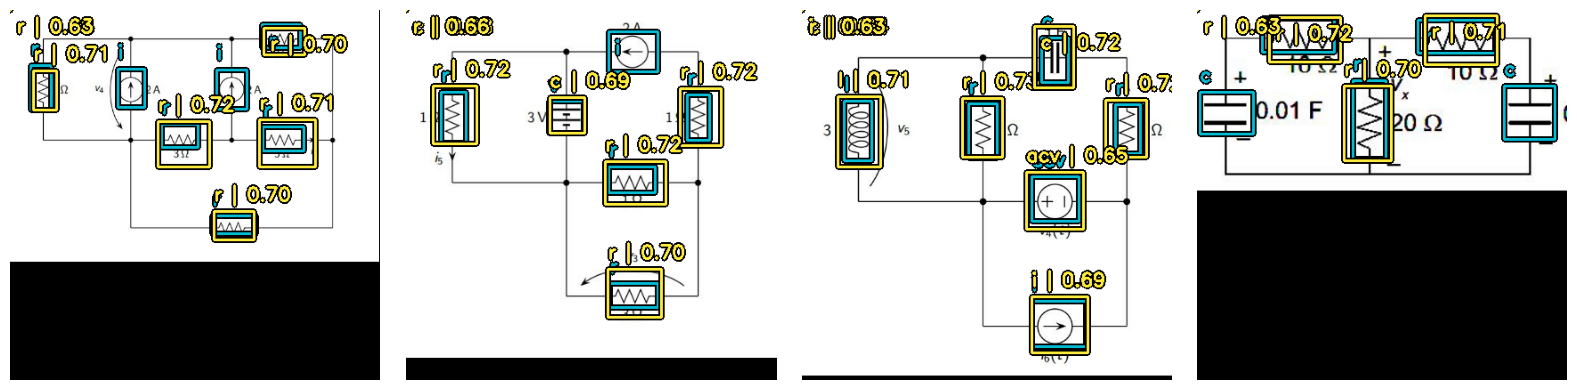

In [ ]:
tf.config.run_functions_eagerly(True)
# Visuaize on test set
visualize_detections(model, dataset=val_dataset.skip(5), bounding_box_format=BBOX_FORMAT, rows=NUM_ROWS, cols=NUM_COLS)
tf.config.run_functions_eagerly(False)

In [18]:
model.load_weights("circuitfasterrcnnmodel.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 88 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
tf.config.run_functions_eagerly(True)
model.evaluate(val_dataset)
tf.config.run_functions_eagerly(False)

100/100 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - MaP: 0.0247 - MaP@[IoU=50]: 0.1074 - MaP@[IoU=75]: 0.0053 - MaP@[area=large]: 0.0000e+00 - MaP@[area=medium]: 0.0298 - MaP@[area=small]: 0.0145 - Recall@[area=large]: 0.0000e+00 - Recall@[area=medium]: 0.0751 - Recall@[area=small]: 0.0461 - Recall@[max_detections=100]: 0.0648 - Recall@[max_detections=10]: 0.0648 - Recall@[max_detections=1]: 0.0463 - box_loss: 0.1665 - classification_loss: 0.3624 - loss: 0.6017 - rpn_box_loss: 0.0283 - rpn_classification_loss: 0.0445


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Resize and pad images
inference_resizing = keras_cv.layers.Resizing(
    IMG_SIZE, IMG_SIZE, pad_to_aspect_ratio=True, bounding_box_format=BBOX_FORMAT
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'boxes': array([[[193.91443 ,  84.88559 , 244.03595 , 147.14464 ],
        [281.508   ,   9.431099, 311.18805 ,  69.22229 ],
        [261.06934 , 172.27873 , 335.03766 , 217.40135 ],
        [101.60753 , 307.2954  , 183.01393 , 358.5329  ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [108.84515 , 164.29329 , 170.79117 , 228.37874 ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [ 33.719734,  86.553116,  91.02329 , 149.99638 ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ]]], dtype=float32), 'confidence': array([[0.7263341 , 0.7223751 , 0.71712613, 0.7027636 , 0.6642509 ,
        0.6550238 , 0.64704746, 0.6467194 , 0.64631647, 0.6396803 ]],
      dtype=float32), 'classes': array([[5., 2., 5., 4., 2., 1., 5., 3., 2., 3.]], dtype=float32), 'num_detections': array([10], dtype=int32)}


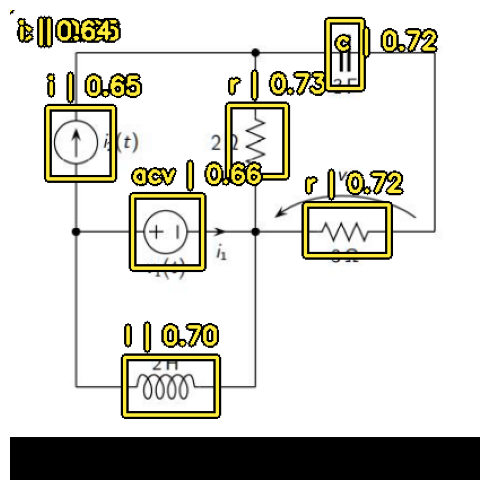

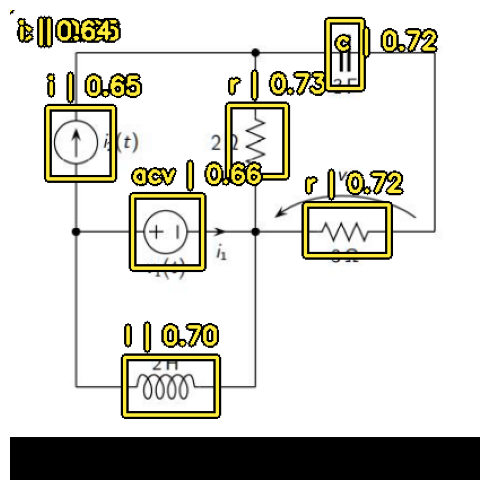

In [ ]:
# Load and preprocess image
image = cv2.imread("/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid/autockt_-565_png.rf.3987d6157512299e3b8ff59eee1d6a0c.jpg")
image = np.array(image)
image_batch = inference_resizing([image])

# Temporarily enable eager execution to avoid XLA compilation issues with NMS
tf.config.run_functions_eagerly(True)

# Run prediction
y_pred = model.predict(image_batch)

# Disable eager execution after prediction
tf.config.run_functions_eagerly(False)

print(y_pred)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
keras_cv.visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=BBOX_FORMAT,
    class_mapping=class_mapping
)


In [19]:
def compute_iou(box1, box2):
    # box1: (4,)   box2: (N,4)
    b1 = tf.expand_dims(box1, axis=0)

    # intersection
    inter_y1 = tf.maximum(b1[:, 0], box2[:, 0])
    inter_x1 = tf.maximum(b1[:, 1], box2[:, 1])
    inter_y2 = tf.minimum(b1[:, 2], box2[:, 2])
    inter_x2 = tf.minimum(b1[:, 3], box2[:, 3])

    inter_area = tf.maximum(inter_y2 - inter_y1, 0) * tf.maximum(inter_x2 - inter_x1, 0)

    # areas
    area1 = (b1[:, 2] - b1[:, 0]) * (b1[:, 3] - b1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # union
    union = area1 + area2 - inter_area

    return inter_area / (union + 1e-7)

def custom_nms(boxes, scores, iou_threshold=0.5, max_output=10):
    idxs = tf.argsort(scores, direction="DESCENDING")
    selected = []

    while tf.size(idxs) > 0 and len(selected) < max_output:
        current = idxs[0]
        selected.append(current.numpy())

        if tf.size(idxs) == 1:
            break

        rest = idxs[1:]
        ious = compute_iou(boxes[current], tf.gather(boxes, rest))

        idxs = tf.gather(rest, tf.where(ious < iou_threshold)[:, 0])

    return selected

In [21]:
# Load and preprocess image
image = cv2.imread("/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid/autockt_-857_png.rf.1064abce6c30647c81b13b7884956972.jpg")
image = np.array(image)
image_batch = inference_resizing([image])

class IdentityDecoder(tf.keras.layers.Layer):
    def __init__(self, bbox_format="xyxy"):
        super().__init__()
        self.bounding_box_format = bbox_format

    def call(self, box, classification=None, training=False, **kwargs):
        return {"boxes": box, "classes": classification}

# Disable KerasCV decoder
model.prediction_decoder = IdentityDecoder(BBOX_FORMAT)

tf.config.run_functions_eagerly(True)
pred = model.predict(image_batch)
tf.config.run_functions_eagerly(False)

for k,v in pred.items():
    print(k, v.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
boxes (1, 1000, 4)
classes (1, 1000, 6)


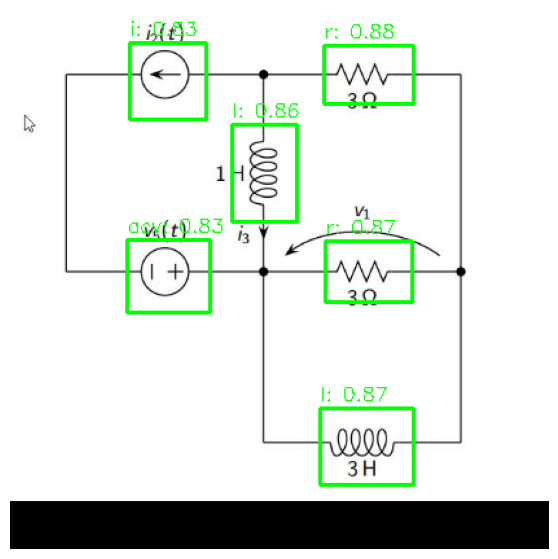

Final detections: 6


In [22]:
# ----------- decode -----------
boxes = tf.squeeze(pred["boxes"], axis=0)          # (1000,4) XYXY absolute pixels
confidence = tf.squeeze(pred["classes"], axis=0)  # (1000,6) class logits

# convert logits -> per-class scores
scores_per_class = tf.nn.sigmoid(confidence)
scores = tf.reduce_max(scores_per_class, axis=-1)   # (1000,)
classes = tf.argmax(scores_per_class, axis=-1)

# threshold
CONF_TH = 0.5
mask = scores >= CONF_TH
boxes = tf.boolean_mask(boxes, mask)
scores = tf.boolean_mask(scores, mask)
classes = tf.boolean_mask(classes, mask)

# xywh -> xyxy (already xyxy)
x1, y1, x2, y2 = tf.split(boxes, 4, axis=-1)
# x1 = x
# y1 = y
# x2 = x + w
# y2 = y + h
boxes_xyxy = tf.concat([x1, y1, x2, y2], axis=-1)

# convert to NMS expected [y1,x1,y2,x2]
boxes_nms = tf.stack([y1[:,0], x1[:,0], y2[:,0], x2[:,0]], axis=1)

# NMS
selected_indices = custom_nms(boxes_nms, scores, iou_threshold=0.2)

# Ensure indices are integers for tf.gather
selected_indices_tensor = tf.constant(selected_indices, dtype=tf.int32)

boxes_xyxy = tf.gather(boxes_xyxy, selected_indices_tensor)
scores     = tf.gather(scores, selected_indices_tensor)
classes    = tf.gather(classes, selected_indices_tensor)

# remove very small boxes (AFTER NMS)
x1, y1, x2, y2 = tf.split(boxes_xyxy, 4, axis=-1)

area = (x2 - x1) * (y2 - y1)
MIN_AREA = 25.0   # 5x5 pixels
size_mask = area[:,0] >= MIN_AREA

boxes_xyxy = tf.boolean_mask(boxes_xyxy, size_mask)
scores     = tf.boolean_mask(scores, size_mask)
classes    = tf.boolean_mask(classes, size_mask)

final_pred = {
    "boxes": boxes_xyxy.numpy(),
    "classes": classes.numpy(),
    "confidence": scores.numpy()
}

# ---------- Visualization ----------
img_vis = image_batch[0].numpy().astype(np.uint8).copy()

for (x1, y1, x2, y2), cls, conf in zip(
        final_pred["boxes"],
        final_pred["classes"],
        final_pred["confidence"]):

    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    # draw box
    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0,255,0), 2)

    # label
    label = f"{class_mapping[int(cls)+1]}: {conf:.2f}"
    cv2.putText(img_vis, label, (x1, max(0, y1 - 6)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("Final detections:", len(final_pred["boxes"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


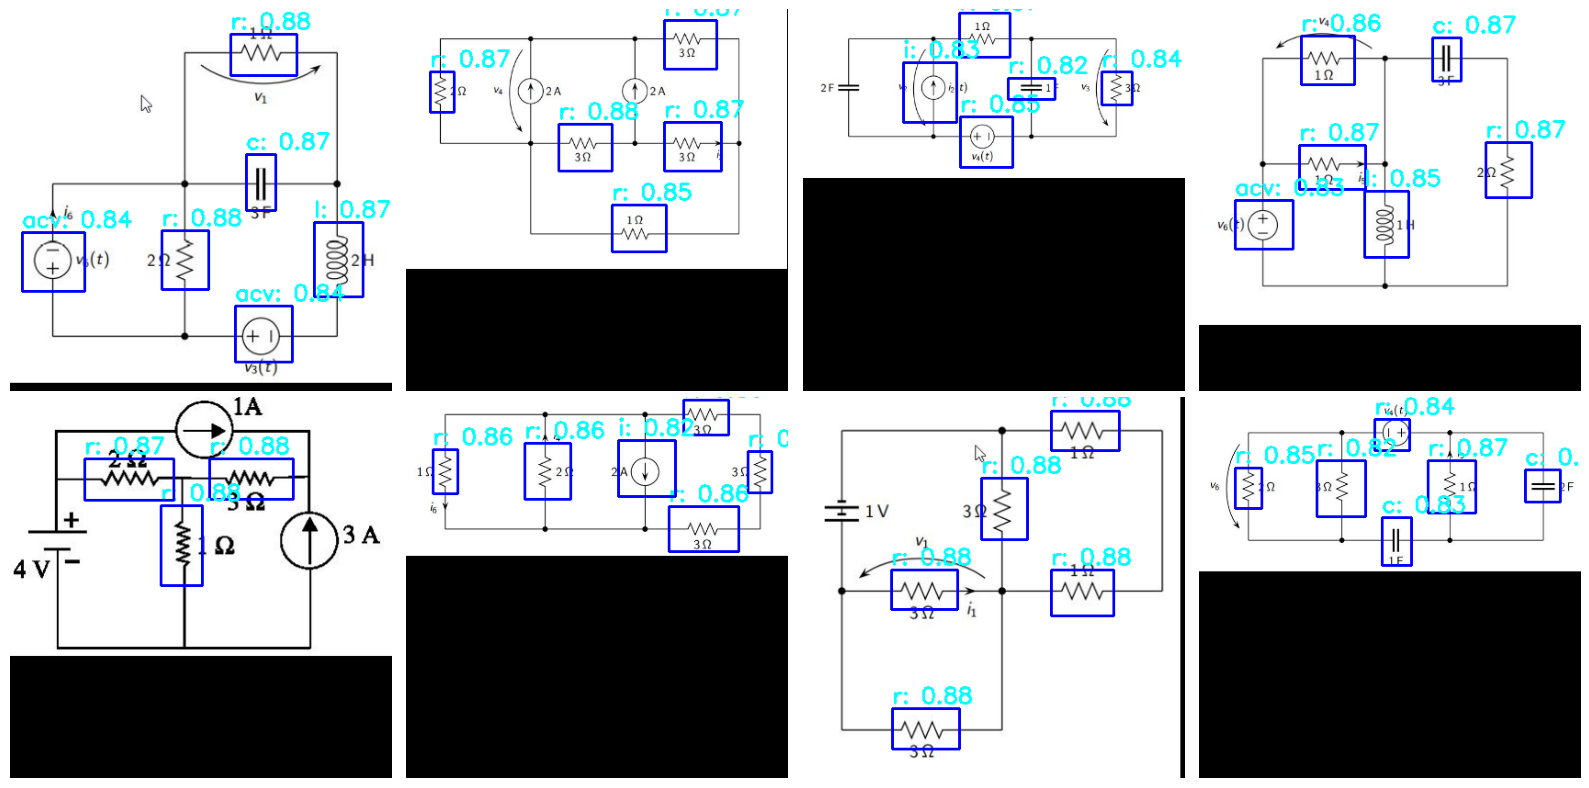

In [ ]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/content/gdrive/My Drive/Tensorflow-Models/circuit/CircuitRecognitioncoco/valid"

class_names = ["acv", "c", "i", "l", "r", "v"]

# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

CONF_TH = 0.5
IOU_TH = 0.2
BLUE = (0, 0, 255)

# ----------------------------------------

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

class IdentityDecoder(tf.keras.layers.Layer):
    def __init__(self, bbox_format="xyxy"):
        super().__init__()
        self.bounding_box_format = bbox_format

    def call(self, box, classification=None, training=False, **kwargs):
        return {"boxes": box, "classes": classification}

# Disable KerasCV decoder
model.prediction_decoder = IdentityDecoder(BBOX_FORMAT)

plt.figure(figsize=(4 * cols, 4 * rows))

for i, img in enumerate(raw_images):

    # resize SINGLE image (same as before)
    image_batch = inference_resizing([img])

    tf.config.run_functions_eagerly(True)
    # predict SINGLE image
    pred = model.predict(image_batch)
    tf.config.run_functions_eagerly(False)

    # ----------- decode -----------
    boxes = tf.squeeze(pred["boxes"], axis=0)          # (1000,4) XYXY absolute pixels
    confidence = tf.squeeze(pred["classes"], axis=0)  # (1000,6) class logits

    # convert logits -> per-class scores
    scores_per_class = tf.nn.sigmoid(confidence)
    scores = tf.reduce_max(scores_per_class, axis=-1)   # (1000,)
    classes = tf.argmax(scores_per_class, axis=-1)

    # threshold
    mask = scores >= CONF_TH
    boxes = tf.boolean_mask(boxes, mask)
    scores = tf.boolean_mask(scores, mask)
    classes = tf.boolean_mask(classes, mask)

    # xywh -> xyxy (already xyxy)
    x1, y1, x2, y2 = tf.split(boxes, 4, axis=-1)
    # x1 = x
    # y1 = y
    # x2 = x + w
    # y2 = y + h
    boxes_xyxy = tf.concat([x1, y1, x2, y2], axis=-1)

    # convert to NMS expected [y1,x1,y2,x2]
    boxes_nms = tf.stack([y1[:,0], x1[:,0], y2[:,0], x2[:,0]], axis=1)

    # NMS
    selected_indices = custom_nms(boxes_nms, scores, iou_threshold=IOU_TH)

    # Ensure indices are integers for tf.gather
    selected_indices_tensor = tf.constant(selected_indices, dtype=tf.int32)

    boxes_xyxy = tf.gather(boxes_xyxy, selected_indices_tensor)
    scores     = tf.gather(scores, selected_indices_tensor)
    classes    = tf.gather(classes, selected_indices_tensor)

    # remove very small boxes (AFTER NMS)
    x1, y1, x2, y2 = tf.split(boxes_xyxy, 4, axis=-1)

    area = (x2 - x1) * (y2 - y1)
    MIN_AREA = 25.0   # 5x5 pixels
    size_mask = area[:,0] >= MIN_AREA

    boxes_xyxy = tf.boolean_mask(boxes_xyxy, size_mask)
    scores     = tf.boolean_mask(scores, size_mask)
    classes    = tf.boolean_mask(classes, size_mask)

    final_pred = {
        "boxes": boxes_xyxy.numpy(),
        "classes": classes.numpy(),
        "confidence": scores.numpy()
    }

    # visualization
    img_vis = image_batch[0].numpy().astype(np.uint8).copy()

    for (x1, y1, x2, y2), cls, conf in zip(
        final_pred["boxes"],
        final_pred["classes"],
        final_pred["confidence"]):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(
            img_vis,
            f"{class_names[int(cls)]}: {conf:.2f}",
            (x1, max(0, y1 - 6)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 0),
            2
        )

    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()